In [ ]:
import numpy as np
import tensorflow as tf

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

2022-09-08 11:13:21.155662: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2022-09-08 11:13:21.155737: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
from maddeb.FlowVAEnet import FlowVAEnet
from maddeb.utils import listdir_fullpath
import seaborn as sns

In [ ]:
linear_norm_coeff = 80000

## Load images

In [ ]:
bands = [4,5,6,7,8,9]

######## List of data samples
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d) if not f.endswith("metadata.npy")]

train_path_isolated_gal = listdir_fullpath(
    "/sps/lsst/users/bbiswas/simulations/COSMOS_btk_isolated_train/"
)
validation_path_isolated_gal = listdir_fullpath(
    "/sps/lsst/users/bbiswas/simulations/COSMOS_btk_isolated_validation/"
)

# Take 1000 images from the first file.
images = np.load(validation_path_isolated_gal[0], allow_pickle=True)

## Convernt image to linear normalization
Note that the images were non-linearly normalized before being saved. So do denormalization first.

In [ ]:
isolated_images = images['isolated_gal_stamps']

Text(0.5, 1.0, 'difference')

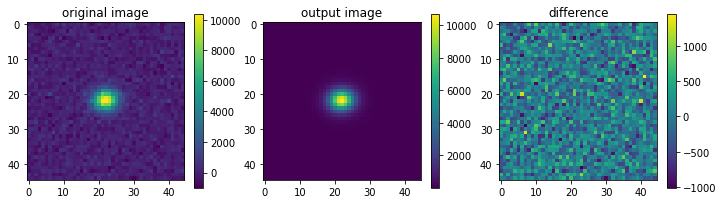

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

image_num = 40

im = axs[0].imshow(images['blended_gal_stamps'][image_num][:, :, 2])
fig.colorbar(im, ax=axs[0], shrink=0.8)
axs[0].set_title("original image")

im = axs[1].imshow(images['isolated_gal_stamps'][image_num][:, :, 2])
fig.colorbar(im, ax=axs[1], shrink=0.8)
axs[1].set_title("output image")


difference = images['blended_gal_stamps'][image_num][:, :, 2] - images['isolated_gal_stamps'][image_num][:, :, 2]
im = axs[2].imshow(difference)
fig.colorbar(im, ax=axs[2],shrink=0.8)
axs[2].set_title("difference")

In [ ]:
images_isolated_normed = np.array(np.array(images['isolated_gal_stamps'].tolist()))/linear_norm_coeff
#images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))

images_blended_normed = np.array(np.array(images['blended_gal_stamps'].tolist()))/linear_norm_coeff
#images_blended_normed = np.transpose(images_blended_normed, axes=(0, 2, 3, 1))

## Load trained models

In [ ]:
from maddeb.utils import get_data_dir_path

data_dir = get_data_dir_path()

tf.get_logger().setLevel('ERROR')
latent_dim = 8
flow_net = FlowVAEnet(latent_dim=latent_dim)
flow_net.load_flow_weights(weights_path=os.path.join(data_dir, "cosmos8d/flow/val_loss"))
flow_net.load_vae_weights(weights_path=os.path.join(data_dir, "cosmos8d/vae/val_loss"))
print(flow_net.vae_model.summary())

2022-09-08 11:13:38.572895: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2022-09-08 11:13:38.572968: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-08 11:13:38.573079: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-09-08 11:13:38.584181: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2499995000 Hz
2022-09-08 11:13:38.585026: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5576cfcd8070 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-08 11:13:38.585061: I tensorflow/compiler/xla

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 45, 45, 6)]       0         
_________________________________________________________________
encoder (Functional)         (None, 44)                2831084   
_________________________________________________________________
latent_space (MultivariateNo ((None, 8), (None, 8))    0         
_________________________________________________________________
decoder (Functional)         (None, 45, 45, 6)         1562022   
Total params: 4,393,106
Trainable params: 4,393,106
Non-trainable params: 0
_________________________________________________________________
None


2022-09-08 11:13:47.152518: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Section 1: Test the VAE

### Section 1.1 reconstructions.
If the VAE is able to correctly reconstruct images, we can conclude that the decoder can be used as a generative model

In [ ]:
tf.get_logger().setLevel('ERROR')
model_vae_output_isolated = flow_net.vae_model(images_blended_normed)

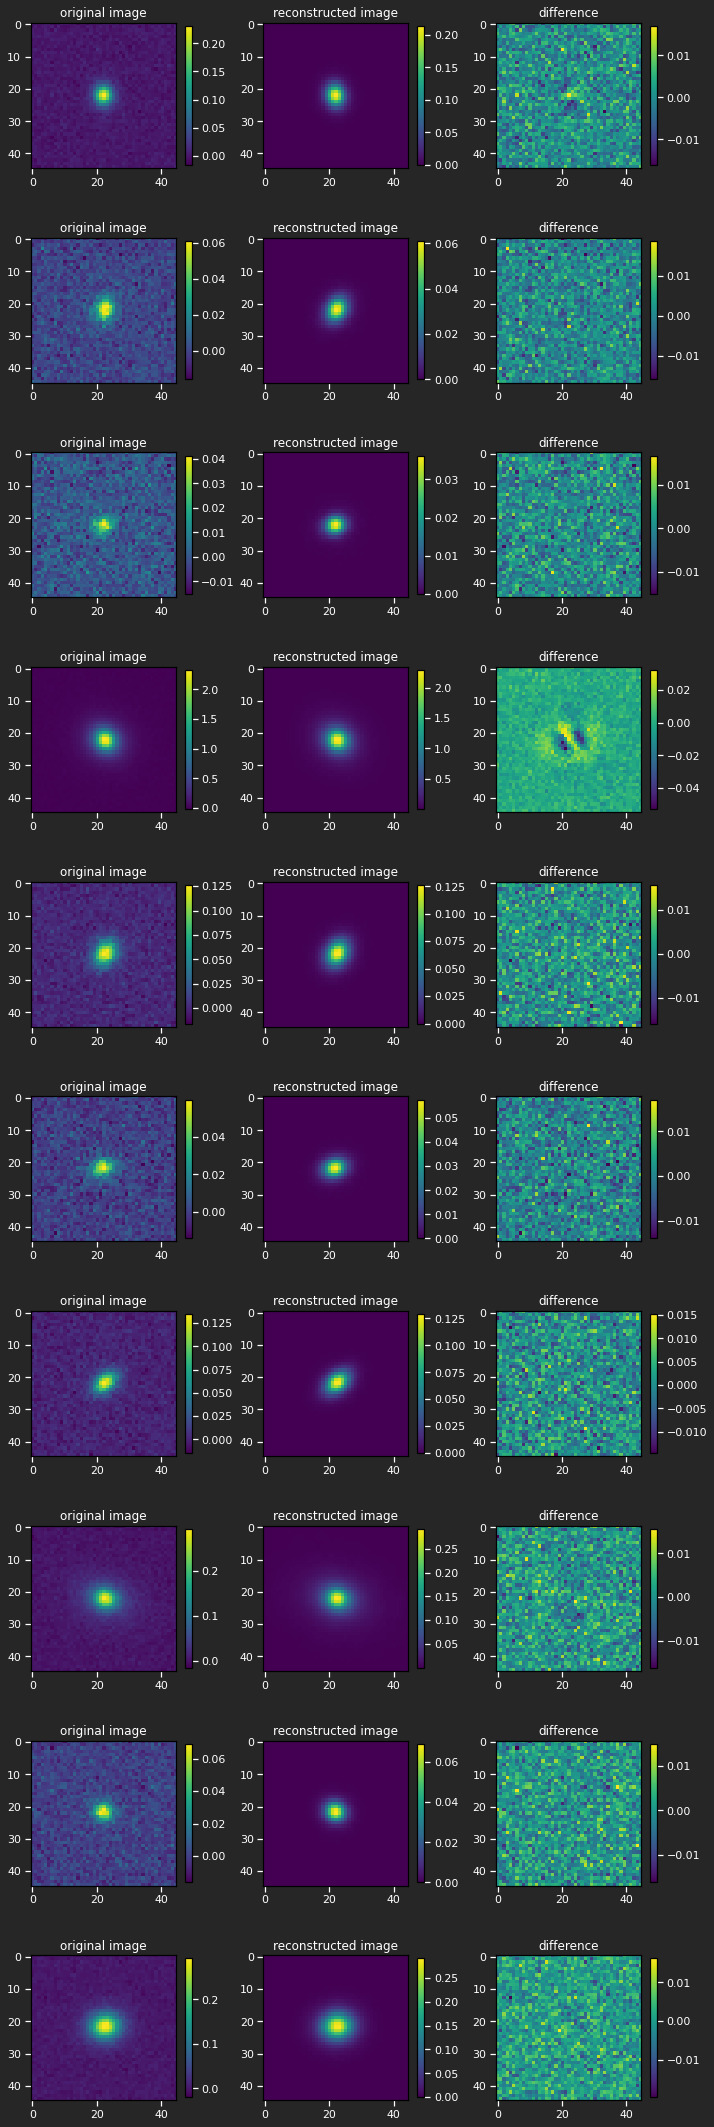

In [ ]:
sns.set_theme(style={"axes.grid": False,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

fig, axs = plt.subplots(10, 3, figsize=(10,30))
for i in range(10):
    
    image_num = i+30
    im = axs[i, 0].imshow(images_blended_normed[image_num][:, :, 2])
    fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    axs[i, 0].set_title("original image")

    im = axs[i, 1].imshow(model_vae_output_isolated.numpy()[image_num][ :, :, 2])
    fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    axs[i, 1].set_title("reconstructed image")


    difference = images_blended_normed[image_num][:, :, 2] - model_vae_output_isolated.numpy()[image_num][ :, :, 2]
    im = axs[i, 2].imshow(difference)
    fig.colorbar(im, ax=axs[i, 2],shrink=0.8)
    axs[i, 2].set_title("difference")

plt.tight_layout()

In [ ]:
import tensorflow_probability as tfp
z = tfp.layers.MultivariateNormalTriL(event_size=latent_dim)(flow_net.encoder(images_isolated_normed))

Conclusion: The reconstructions of galaxies work fairly well! <br>
So the decoder can be used as a generative model by sampling from the latent space.

### Section 1.2 Latent space distribution

In this section we aim to study the latent space distribution of galaxies as learnt by the VAE

In [ ]:
images = np.load(validation_path_isolated_gal[0], allow_pickle=True)

In [ ]:
latent_vars = []
for i in range(10):
    images_i = np.load(validation_path_isolated_gal[i], allow_pickle=True)
    images_isolated_normed = np.array(np.array(images_i['isolated_gal_stamps'].tolist()))/linear_norm_coeff
    #images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))
    
    z = tfp.layers.MultivariateNormalTriL(event_size=latent_dim)(flow_net.encoder(images_isolated_normed))

    latent_vars.extend(list(z.sample().numpy()))
latent_vars = np.array(latent_vars)

In [ ]:
latent_vars_list =[]
for i in range(latent_dim):
    latent_vars_list.append(latent_vars[:, i])

In [ ]:
print(len(latent_vars_list))

8


Text(0, 0.5, 'distribution')

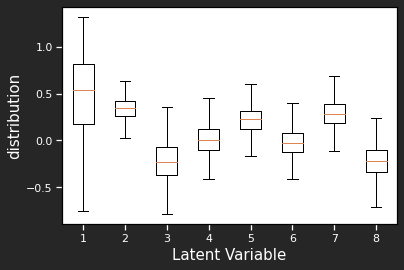

In [ ]:
plt.boxplot(latent_vars_list, showfliers=False)
plt.xlabel("Latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

The plot shows the distribution of the latent space variables as learnt by the VAE. <br>
In the next section we will try to see if we can model this distribution using the Normalizing Flow network. 

# Section 2. Test the flow network

### Section 2.1 Likelihood distribution

In [ ]:
train_path_blended_gal = listdir_fullpath(
    "/sps/lsst/users/bbiswas/simulations/COSMOS_btk_blended_train/"
)
validation_path_blended_gal = listdir_fullpath(
    "/sps/lsst/users/bbiswas/simulations/COSMOS_btk_blended_validation/"
)
# Take 1000 images from the first file.
images_blended = np.load(validation_path_blended_gal[0], allow_pickle=True)

In [ ]:
images_isolated_normed = np.array(np.array(images_blended['isolated_gal_stamps'].tolist()))/linear_norm_coeff
#images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))

images_blended_normed = np.array(np.array(images_blended['blended_gal_stamps'].tolist()))/linear_norm_coeff
#images_blended_normed = np.transpose(images_blended_normed, axes=(0, 2, 3, 1))

In [ ]:
isolated_likelihood = flow_net.flow_model(images_isolated_normed)
noisy_likelihood = flow_net.flow_model(images_blended_normed)

likelihood_difference=isolated_likelihood-noisy_likelihood

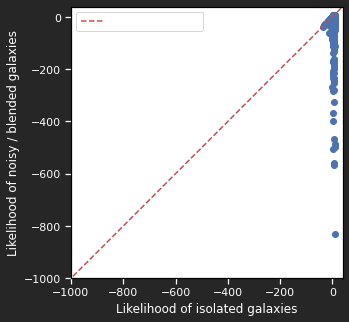

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.scatter(isolated_likelihood, noisy_likelihood)
max_lim = max(np.amax(isolated_likelihood), np.amax(noisy_likelihood))
min_lim = min(np.amin(isolated_likelihood), np.amin(noisy_likelihood))
plt.xlim(-1000, max_lim+30)
plt.ylim(-1000, max_lim+30)
plt.plot((min_lim, max_lim+300), (min_lim, max_lim+300), ls="--", c="r", label="equal likelihood")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel("Likelihood of isolated galaxies", fontsize=12)
plt.ylabel("Likelihood of noisy / blended galaxies", fontsize=12)
plt.legend()

In [ ]:
#plt.hist(likelihood_difference.numpy(), bins=30);

### Section 2.2 Learnt latent space distribution

Finally, let's try to see the distribution of latent variables learnt by the normalizing flow:

In [ ]:
sampled_latent_vars = flow_net.td.sample(len(latent_vars_list[0])).numpy()
sampled_latent_vars_list =[]
for i in range(latent_dim):
    sampled_latent_vars_list.append(sampled_latent_vars[:, i])

In [ ]:
print(len(sampled_latent_vars))

2000


Text(0, 0.5, 'distribution')

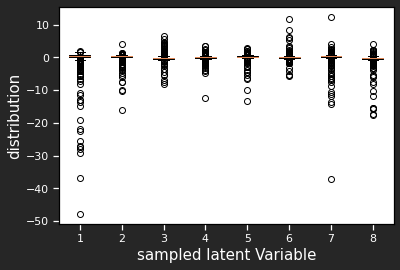

In [ ]:
plt.boxplot(sampled_latent_vars_list, showfliers=True);
plt.xlabel("sampled latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

On comparing the sampled latent space distribution with the actual distribution, we see by eye that the flow nework is able to learn the complex distribution in the latent space.

In [ ]:
latent_value=[]
latent_var_num=[]
latent_type=[]

for i in range(latent_dim):
    latent_value.extend(list(latent_vars_list[i]))
    latent_var_num.extend([i]*len(latent_vars_list[i]))
    latent_type.extend(["actual"]*len(latent_vars_list[i]))
    
    latent_value.extend(list(sampled_latent_vars_list[i]))
    latent_var_num.extend([i]*len(sampled_latent_vars_list[i]))
    latent_type.extend(["learnt"]*len(sampled_latent_vars_list[i]))
    
df_plot ={"latent_value": latent_value, "latent_var_num":latent_var_num, "latent_type":latent_type}

In [ ]:
import pandas as pd
df_plot = pd.DataFrame(df_plot)

In [ ]:
df_plot

,latent_value,latent_var_num,latent_type
0,-0.884897,0,actual
1,0.569560,0,actual
2,1.105424,0,actual
3,0.289379,0,actual
4,0.430760,0,actual
...,...,...,...
31995,-0.194212,7,learnt
31996,-0.203620,7,learnt
31997,0.033419,7,learnt
31998,-0.186498,7,learnt


In [ ]:
import seaborn as sns

(-3.0, 3.0)

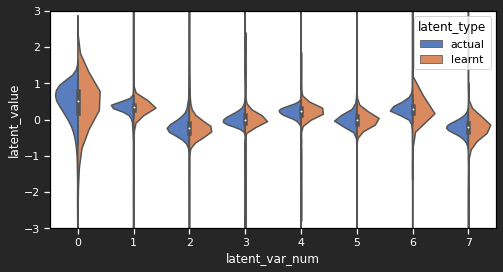

In [ ]:
sns.set_theme(style={'text.color': 'black'})
f, ax = plt.subplots(figsize=(8, 4))
ax = sns.violinplot(x="latent_var_num", y="latent_value", hue="latent_type",
                    data=df_plot, palette="muted", cut=2, split=True, scale="width", scale_hue=False)
ax.set_ylim(-3,3)

##### 

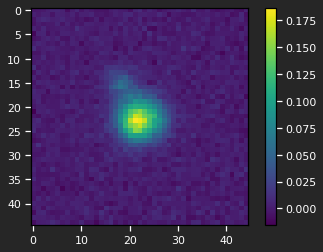

In [ ]:
image_num = 30
im = plt.imshow(images_blended_normed[image_num][:, :, 2]);
ax=plt.gca()
plt.colorbar(im, ax=ax)

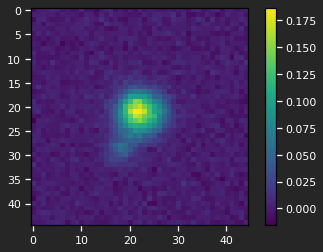

In [ ]:
flipped = np.flip(images_blended_normed, axis=1)
plt.imshow(flipped[30, :, :, 2])
ax=plt.gca()
plt.colorbar(im, ax=ax)

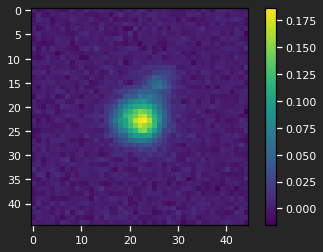

In [ ]:
flipped = np.flip(images_blended_normed, axis=2)
plt.imshow(flipped[30, :, :, 2])
ax=plt.gca()
plt.colorbar(im, ax=ax)

In [ ]:
flipped = np.flip(np.flip(images_blended_normed, axis=1), axis=2)
plt.imshow(flipped[30, :, :, 2])
ax=plt.gca()
plt.colorbar(im, ax=ax)